In [22]:
%store -r stats area_downwind_km2 area_upwind_km2 area_urban_km2 urban_radius city_center clipped_urban_circle clipped_downwind_wedge clipped_upwind_wedge


In [23]:
import numpy as np
import xarray as xr
from shapely.geometry import Point

In [24]:
# Read cell tracking data
time_res = stats.attrs['time_resolution_hour']
pixel_radius = stats.attrs['pixel_radius_km']

# Get cell initial location
cell_lon0 = stats['cell_meanlon'].isel(times=0)
# Find tracks where initiation longitude is not NaN
# These tracks are problematic and should be excluded
ind = np.where(~np.isnan(cell_lon0))[0]

# Subset the tracks
stats = stats.isel(tracks=ind).load()
ntracks = stats.dims['tracks']
print(f'Number of valid tracks: {ntracks}')


tracks = stats['tracks']
times = stats['times']

lifetime = stats['track_duration'] * time_res
start_time = stats['start_basetime']
end_time = stats['end_basetime']
end_merge_tracknumber = stats['end_merge_tracknumber']
start_split_tracknumber = stats['start_split_tracknumber']
cell_lon = stats['cell_meanlon']
cell_lat = stats['cell_meanlat']
cell_area = stats['cell_area']
maxrange_flag = stats['maxrange_flag']

maxdbz = stats['max_dbz']
eth20 = stats['maxETH_20dbz']

Number of valid tracks: 54932


### Obtain cell start and end locations

In [25]:
# Get track start values
start_maxrange_flag = maxrange_flag.isel(times=0)
start_lon = cell_lon.isel(times=0)
start_lat = cell_lat.isel(times=0)

# Get duration (lifetime counts) and maxrange_flag in Numpy arrays for speed
duration = (lifetime.values / time_res).astype(int)
rangeflag = maxrange_flag.values
celllon = cell_lon.values
celllat = cell_lat.values

end_maxrange_flag = np.ones(ntracks, dtype=float)
end_lon = np.full(ntracks, np.NaN, dtype=float)
end_lat = np.full(ntracks, np.NaN, dtype=float)

# Get track last valid value
for ii in range(0, ntracks):
    # Get duration for the track
    iduration = duration[ii]
    # Get valid values for the track
    imaxrangeflag = rangeflag[ii,0:iduration]
    icell_lon = celllon[ii,0:iduration]
    icell_lat = celllat[ii,0:iduration]
    
    # Get last value from the track
    end_maxrange_flag[ii] = imaxrangeflag[-1]
    end_lon[ii] = icell_lon[-1]
    end_lat[ii] = icell_lat[-1]

### Find merge/split tracks

In [26]:
# Get track start/end hour
start_hour = start_time.dt.hour
end_hour = end_time.dt.hour

# Find tracks not end with merge or not start with split
nonmerge = np.where(np.isnan(end_merge_tracknumber))[0]
nonsplit = np.where(np.isnan(start_split_tracknumber))[0]
ntracks_nonmerge = len(nonmerge)
ntracks_nonsplit = len(nonsplit)
print(f'Number of non-merge tracks: {ntracks_nonmerge}')
print(f'Number of non-split tracks: {ntracks_nonsplit}')

nonsplit_in = np.where(np.isnan(start_split_tracknumber) & (start_maxrange_flag == 1))[0]
nonmerge_in = np.where(np.isnan(end_merge_tracknumber) & (end_maxrange_flag == 1))[0]
ntracks_nonsplit_in = len(nonsplit_in)
ntracks_nonmerge_in = len(nonmerge_in)
print(f'Number of non-split tracks within max range: {ntracks_nonsplit_in}')
print(f'Number of non-merge tracks within max range: {ntracks_nonmerge_in}')

merge = np.where(end_merge_tracknumber > 0)[0]
split = np.where(start_split_tracknumber > 0)[0]
ntracks_merge = len(merge)
ntracks_split = len(split)
print(f'Number of merge tracks: {ntracks_merge}')
print(f'Number of split tracks: {ntracks_split}')

Number of non-merge tracks: 44961
Number of non-split tracks: 45255
Number of non-split tracks within max range: 0
Number of non-merge tracks within max range: 0
Number of merge tracks: 9971
Number of split tracks: 9677


In [27]:
# Get initiation and time
hour_bin = np.arange(0, 25, 1)

hist_starthour, bins = np.histogram(start_hour, bins=hour_bin, range=(0,24), density=False)
hist_starthour_in, bins = np.histogram(start_hour.isel(tracks=nonmerge_in), bins=hour_bin, range=(0,24), density=False)

hist_endhour, bins = np.histogram(end_hour, bins=hour_bin, range=(0,24), density=False)
hist_endhour_in, bins = np.histogram(end_hour.isel(tracks=nonmerge_in), bins=hour_bin, range=(0,24), density=False)


# Convert to local time (UTC-6)
hist_starthour_LT = np.roll(hist_starthour, -6)
hist_starthour_in_LT = np.roll(hist_starthour_in, -6)

hist_endhour_LT = np.roll(hist_endhour, -6)
hist_endhour_in_LT = np.roll(hist_endhour_in, -6)

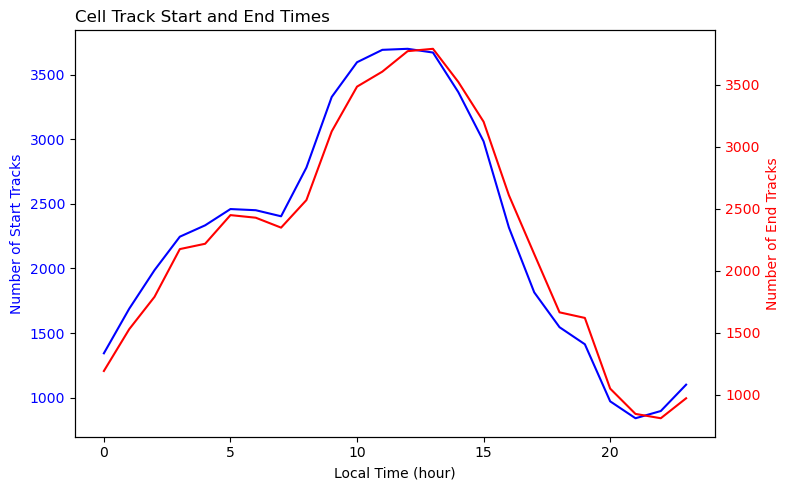

In [28]:
import matplotlib.pyplot as plt

# Assuming hour_bin, hist_starthour_LT, hist_endhour_LT are already defined

fig, ax1 = plt.subplots(figsize=[8, 5], dpi=100)

# Plotting for cell track start times on the first y-axis
ax1.plot(hour_bin[:-1], hist_starthour_LT, label='Start tracks', color='b')
ax1.set_xlabel('Local Time (hour)')
ax1.set_ylabel('Number of Start Tracks', color='b')
ax1.tick_params(axis='y', labelcolor='b')
#ax1.grid(ls='--')
ax1.set_title('Cell Track Start and End Times', loc='left')
# ax1.legend(loc='upper left')

# Setting up the second y-axis for cell track end times
ax2 = ax1.twinx()
ax2.plot(hour_bin[:-1], hist_endhour_LT, label='End tracks', color='r')
ax2.set_ylabel('Number of End Tracks', color='r')
ax2.tick_params(axis='y', labelcolor='r')
# ax2.legend(loc='upper right')

fig.tight_layout()
plt.show()


## Extract storms in the urban area

In [29]:
# Initiation at urban area
def lat_lon_to_cartesian(lat, lon, R=6371):
    x = R * np.radians(lon)
    y = R * np.radians(lat)
    return x, y

center_lat, center_lon, radius = city_center[1], city_center[0], 76.35
center_x, center_y = lat_lon_to_cartesian(center_lat, center_lon)
storm_x, storm_y = lat_lon_to_cartesian(start_lat, start_lon)
distances = np.sqrt((storm_x - center_x)**2 + (storm_y - center_y)**2)
storms_in_circle = start_hour[distances <= radius]
hist_storms_in_circle, bins = np.histogram(storms_in_circle, bins=hour_bin, range=(0, 24), density=False)
hist_storms_in_circle_LT = np.roll(hist_storms_in_circle, -6)

# Fraction of E.SDC tracks to all tracks
hist_storms_in_circle_LT_frac = 100 * (hist_storms_in_circle_LT / hist_starthour_LT)

## Extract storms in the upwind and downwind areas

In [30]:
storm_points = [Point(lon, lat) for lon, lat in zip(start_lon, start_lat)]

# Filter storms in the downwind wedge
storms_in_downwind_wedge = [start_hour[i] for i, point in enumerate(storm_points) if clipped_downwind_wedge.contains(point)]
storms_in_downwind_wedge = xr.concat(storms_in_downwind_wedge, dim='tracks')
hist_storms_in_downwind_wedge, bins = np.histogram(storms_in_downwind_wedge, bins=hour_bin, range=(0, 24), density=False)
hist_storms_in_downwind_wedge_LT = np.roll(hist_storms_in_downwind_wedge, -6)
hist_storms_in_downwind_wedge_LT_frac = 100 * (hist_storms_in_downwind_wedge_LT / hist_starthour_LT)


# Filter storms in the upwind wedge
storms_in_upwind_wedge = [start_hour[i] for i, point in enumerate(storm_points) if clipped_upwind_wedge.contains(point)]
storms_in_upwind_wedge = xr.concat(storms_in_upwind_wedge, dim='tracks')
hist_storms_in_upwind_wedge, bins = np.histogram(storms_in_upwind_wedge, bins=hour_bin, range=(0, 24), density=False)
hist_storms_in_upwind_wedge_LT = np.roll(hist_storms_in_upwind_wedge, -6)
hist_storms_in_upwind_wedge_LT_frac = 100 * (hist_storms_in_upwind_wedge_LT / hist_starthour_LT)


## Calculate basic statistics for the urban region

In [31]:
circle = storms_in_circle.tracks.values
stats_circle = stats.sel(tracks=circle)
start_time_circle = stats_circle['start_basetime']
end_time_circle = stats_circle['end_basetime']
start_hour_circle = start_time_circle.dt.hour
end_hour_circle = end_time_circle.dt.hour
cell_lon_circle = stats_circle['cell_meanlon']
cell_lat_circle = stats_circle['cell_meanlat']
cell_area_circle = stats_circle['cell_area']
maxrange_flag_circle = stats_circle['maxrange_flag']
maxdbz_circle = stats_circle['max_dbz']
eth20_circle = stats_circle['maxETH_20dbz']

cell_diam_circle = 2 * np.sqrt(cell_area_circle / np.pi)
cell_diam_mean_circle = cell_diam_circle.mean(dim='times')
cell_area_mean_circle = cell_area_circle.mean(dim='times')
cell_eth20_mean_circle = eth20_circle.mean(dim='times')
cell_maxdbz_mean_circle = maxdbz_circle.mean(dim='times')


In [32]:
# Bin max cell diameter data by initiation hour for box plot
cell_area_mean_hourbin_circle = []
cell_diam_mean_hourbin_circle = []
cell_eth20_mean_hourbin_circle = []
cell_maxdbz_mean_hourbin_circle = []
for ihour in range(24):
    cell_area_mean_hourbin_circle.append(np.log10(cell_area_mean_circle.where(start_hour_circle == ihour, drop=True)).values)
    cell_diam_mean_hourbin_circle.append(cell_diam_mean_circle.where(start_hour_circle == ihour, drop=True).values)
    cell_eth20_mean_hourbin_circle.append(cell_eth20_mean_circle.where((start_hour_circle == ihour) & (~np.isnan(cell_eth20_mean_circle)), drop=True).values)
    cell_maxdbz_mean_hourbin_circle.append(cell_maxdbz_mean_circle.where((start_hour_circle == ihour) & (~np.isnan(cell_maxdbz_mean_circle)), drop=True).values)
    

# Convert to local time (UTC-3) 
# cell_diam_max_hourbin_LT = np.roll(cell_diam_max_hourbin, -3)
# To avoid numpy warning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated
# Convert the ragged list to a numpy object array
cell_diam_mean_hourbin_circle = np.array(cell_diam_mean_hourbin_circle, dtype=object, copy=False, subok=True)
cell_diam_mean_hourbin_LT_circle = np.roll(cell_diam_mean_hourbin_circle, -6)
cell_area_mean_hourbin_circle = np.array(cell_area_mean_hourbin_circle, dtype=object, copy=False, subok=True)
cell_area_mean_hourbin_LT_circle = np.roll(cell_area_mean_hourbin_circle, -6)
cell_eth20_mean_hourbin_circle = np.array(cell_eth20_mean_hourbin_circle, dtype=object, copy=False, subok=True)
cell_eth20_mean_hourbin_LT_circle = np.roll(cell_eth20_mean_hourbin_circle, -6)
cell_maxdbz_mean_hourbin_circle = np.array(cell_maxdbz_mean_hourbin_circle, dtype=object, copy=False, subok=True)
cell_maxdbz_mean_hourbin_LT_circle = np.roll(cell_maxdbz_mean_hourbin_circle, -6)

## Calculate basic statistics for the upwind region

In [33]:
upwind = storms_in_upwind_wedge.tracks.values
stats_upwind = stats.sel(tracks=upwind)
start_time_upwind = stats_upwind['start_basetime']
end_time_upwind = stats_upwind['end_basetime']
start_hour_upwind = start_time_upwind.dt.hour
end_hour_upwind = end_time_upwind.dt.hour
cell_lon_upwind = stats_upwind['cell_meanlon']
cell_lat_upwind = stats_upwind['cell_meanlat']
cell_area_upwind = stats_upwind['cell_area']
maxrange_flag_upwind = stats_upwind['maxrange_flag']
maxdbz_upwind = stats_upwind['max_dbz']
eth20_upwind = stats_upwind['maxETH_20dbz']

cell_diam_upwind = 2 * np.sqrt(cell_area_upwind / np.pi)
cell_diam_mean_upwind = cell_diam_upwind.mean(dim='times')
cell_area_mean_upwind = cell_area_upwind.mean(dim='times')
cell_eth20_mean_upwind = eth20_upwind.mean(dim='times')
cell_maxdbz_mean_upwind = maxdbz_upwind.mean(dim='times')


In [34]:
# Bin max cell diameter data by initiation hour for box plot
cell_area_mean_hourbin_upwind = []
cell_diam_mean_hourbin_upwind = []
cell_eth20_mean_hourbin_upwind = []
cell_maxdbz_mean_hourbin_upwind = []
for ihour in range(24):
    cell_area_mean_hourbin_upwind.append(np.log10(cell_area_mean_upwind.where(start_hour_upwind == ihour, drop=True)).values)
    cell_diam_mean_hourbin_upwind.append(cell_diam_mean_upwind.where(start_hour_upwind == ihour, drop=True).values)
    cell_eth20_mean_hourbin_upwind.append(cell_eth20_mean_upwind.where((start_hour_upwind == ihour) & (~np.isnan(cell_eth20_mean_upwind)), drop=True).values)
    cell_maxdbz_mean_hourbin_upwind.append(cell_maxdbz_mean_upwind.where((start_hour_upwind == ihour) & (~np.isnan(cell_maxdbz_mean_upwind)), drop=True).values)
    

# Convert to local time (UTC-3) 
# cell_diam_max_hourbin_LT = np.roll(cell_diam_max_hourbin, -3)
# To avoid numpy warning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated
# Convert the ragged list to a numpy object array
cell_diam_mean_hourbin_upwind = np.array(cell_diam_mean_hourbin_upwind, dtype=object, copy=False, subok=True)
cell_diam_mean_hourbin_LT_upwind = np.roll(cell_diam_mean_hourbin_upwind, -6)
cell_area_mean_hourbin_upwind = np.array(cell_area_mean_hourbin_upwind, dtype=object, copy=False, subok=True)
cell_area_mean_hourbin_LT_upwind = np.roll(cell_area_mean_hourbin_upwind, -6)
cell_eth20_mean_hourbin_upwind = np.array(cell_eth20_mean_hourbin_upwind, dtype=object, copy=False, subok=True)
cell_eth20_mean_hourbin_LT_upwind = np.roll(cell_eth20_mean_hourbin_upwind, -6)
cell_maxdbz_mean_hourbin_upwind = np.array(cell_maxdbz_mean_hourbin_upwind, dtype=object, copy=False, subok=True)
cell_maxdbz_mean_hourbin_LT_upwind = np.roll(cell_maxdbz_mean_hourbin_upwind, -6)

## Calculate basic statistics for the downwind region

In [35]:
downwind = storms_in_downwind_wedge.tracks.values
stats_downwind = stats.sel(tracks=downwind)
start_time_downwind = stats_downwind['start_basetime']
end_time_downwind = stats_downwind['end_basetime']
start_hour_downwind = start_time_downwind.dt.hour
end_hour_downwind = end_time_downwind.dt.hour
cell_lon_downwind = stats_downwind['cell_meanlon']
cell_lat_downwind = stats_downwind['cell_meanlat']
cell_area_downwind = stats_downwind['cell_area']
maxrange_flag_downwind = stats_downwind['maxrange_flag']
maxdbz_downwind = stats_downwind['max_dbz']
eth20_downwind = stats_downwind['maxETH_20dbz']

cell_diam_downwind = 2 * np.sqrt(cell_area_downwind / np.pi)
cell_diam_mean_downwind = cell_diam_downwind.mean(dim='times')
cell_area_mean_downwind = cell_area_downwind.mean(dim='times')
cell_eth20_mean_downwind = eth20_downwind.mean(dim='times')
cell_maxdbz_mean_downwind = maxdbz_downwind.mean(dim='times')


In [36]:
# Bin max cell diameter data by initiation hour for box plot
cell_area_mean_hourbin_downwind = []
cell_diam_mean_hourbin_downwind = []
cell_eth20_mean_hourbin_downwind = []
cell_maxdbz_mean_hourbin_downwind = []
for ihour in range(24):
    cell_area_mean_hourbin_downwind.append(np.log10(cell_area_mean_downwind.where(start_hour_downwind == ihour, drop=True)).values)
    cell_diam_mean_hourbin_downwind.append(cell_diam_mean_downwind.where(start_hour_downwind == ihour, drop=True).values)
    cell_eth20_mean_hourbin_downwind.append(cell_eth20_mean_downwind.where((start_hour_downwind == ihour) & (~np.isnan(cell_eth20_mean_downwind)), drop=True).values)
    cell_maxdbz_mean_hourbin_downwind.append(cell_maxdbz_mean_downwind.where((start_hour_downwind == ihour) & (~np.isnan(cell_maxdbz_mean_downwind)), drop=True).values)
    

# Convert to local time (UTC-3) 
# cell_diam_max_hourbin_LT = np.roll(cell_diam_max_hourbin, -3)
# To avoid numpy warning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated
# Convert the ragged list to a numpy object array
cell_diam_mean_hourbin_downwind = np.array(cell_diam_mean_hourbin_downwind, dtype=object, copy=False, subok=True)
cell_diam_mean_hourbin_LT_downwind = np.roll(cell_diam_mean_hourbin_downwind, -6)
cell_area_mean_hourbin_downwind = np.array(cell_area_mean_hourbin_downwind, dtype=object, copy=False, subok=True)
cell_area_mean_hourbin_LT_downwind = np.roll(cell_area_mean_hourbin_downwind, -6)
cell_eth20_mean_hourbin_downwind = np.array(cell_eth20_mean_hourbin_downwind, dtype=object, copy=False, subok=True)
cell_eth20_mean_hourbin_LT_downwind = np.roll(cell_eth20_mean_hourbin_downwind, -6)
cell_maxdbz_mean_hourbin_downwind = np.array(cell_maxdbz_mean_hourbin_downwind, dtype=object, copy=False, subok=True)
cell_maxdbz_mean_hourbin_LT_downwind = np.roll(cell_maxdbz_mean_hourbin_downwind, -6)

# Plot all three regions

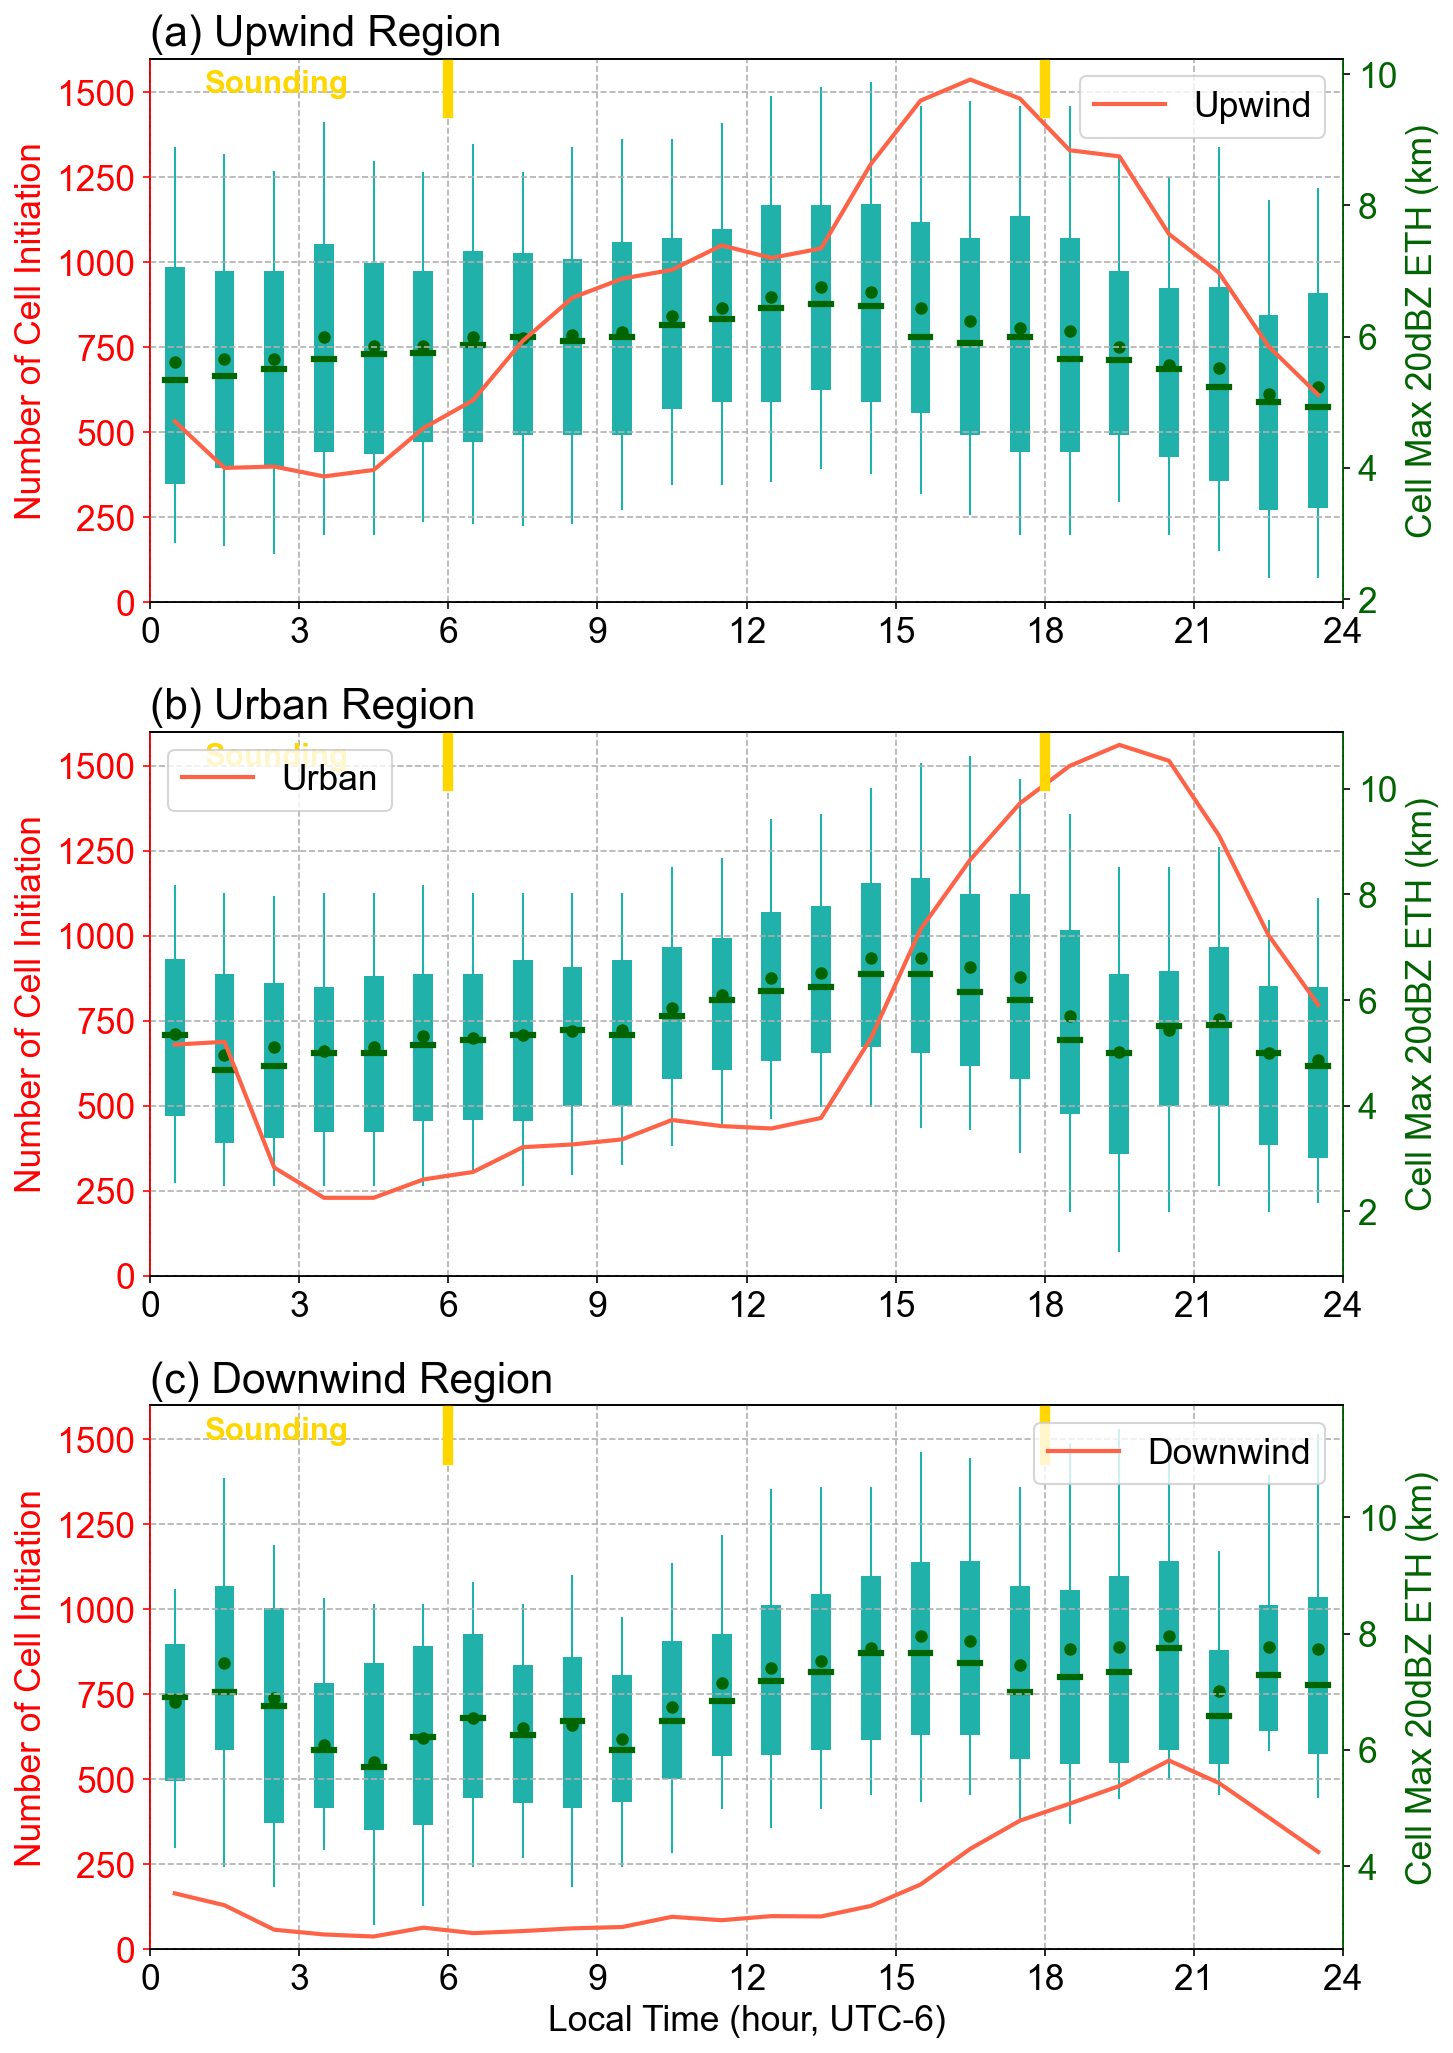

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Set matplotlib parameters
mpl.rcParams['font.size'] = 17
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['figure.facecolor'] = 'white'

# Create a 3-row, 1-column figure
fig, axes = plt.subplots(3, 1, figsize=[10, 14], dpi=150)

# Times and hour bin values
sonde_times = [6, 18]
hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2

#-------------------------------------------
# First subplot (ax1)
ax1 = axes[0]
ax1.plot(hour_binv, hist_storms_in_upwind_wedge, color='tomato', lw=2, label='Upwind')
ax1.legend(loc='upper right', ncol=2)
ax1.grid(ls='--')
ax1.set_title('(a) Upwind Region', loc='left')
ax1.set_ylabel('Number of Cell Initiation')
ax1.set_ylim(0, 1600)
ax1.set_xticks(np.arange(0,24.1,3))
ax1.set_xlim(0,24)
ax1.yaxis.label.set_color('red')
ax1.tick_params(axis='y', colors='red')
for ll in range(len(sonde_times)):
    ax1.axvline(sonde_times[ll], ymin=0.9, ymax=1, color='gold', lw=5)
ax1.text(4, 1500, 'Sounding', color='gold', ha='right', fontsize=15, fontweight='bold')

# Boxplot settings
boxprops_ = dict(linestyle='-', linewidth=0, color='none', facecolor='lightseagreen', alpha=1)
medianprops_ = dict(linestyle='-', linewidth=3, color='darkgreen')
meanpointprops_ = dict(marker='o', markeredgecolor='darkgreen', markerfacecolor='darkgreen', markersize=5)
whiskerprops_ = dict(linewidth=1, linestyle='-', color='lightseagreen')

ax1b = ax1.twinx()
bp1 = ax1b.boxplot(cell_eth20_mean_hourbin_LT_upwind, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
                  boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
                  showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
ax1b.set_ylabel('Cell Max 20dBZ ETH (km)', color='darkgreen')
ax1b.tick_params(axis='y', labelcolor='darkgreen')
ax1.set_zorder(2)
ax1.patch.set_visible(False)
ax1.spines['left'].set_color('red')
ax1.spines['right'].set_color('darkgreen')

#-----------------------------------------------
# Second subplot (ax2)
ax2 = axes[1]
ax2.plot(hour_binv, hist_storms_in_circle, color='tomato', lw=2, label='Urban')
ax2.legend(loc='upper left', ncol=2)
ax2.grid(ls='--')
ax2.set_title('(b) Urban Region', loc='left')
ax2.set_ylabel('Number of Cell Initiation')
ax2.set_ylim(0, 1600)
ax2.set_xticks(np.arange(0,24.1,3))
ax2.set_xlim(0,24)
ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')
for ll in range(len(sonde_times)):
    ax2.axvline(sonde_times[ll], ymin=0.9, ymax=1, color='gold', lw=5)
ax2.text(4, 1500, 'Sounding', color='gold', ha='right', fontsize=15, fontweight='bold')

ax2b = ax2.twinx()
bp2 = ax2b.boxplot(cell_eth20_mean_hourbin_LT_circle, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
                  boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
                  showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
ax2b.set_ylabel('Cell Max 20dBZ ETH (km)', color='darkgreen')
ax2b.tick_params(axis='y', labelcolor='darkgreen')
ax2.set_zorder(2)
ax2.patch.set_visible(False)
ax2.spines['left'].set_color('red')
ax2.spines['right'].set_color('darkgreen')

#-----------------------------------------------
# Third subplot (ax3)
ax3 = axes[2]
ax3.plot(hour_binv, hist_storms_in_downwind_wedge, color='tomato', lw=2, label='Downwind')
ax3.legend(loc='upper right', ncol=2)
ax3.grid(ls='--')
ax3.set_title('(c) Downwind Region', loc='left')
ax3.set_ylabel('Number of Cell Initiation')
ax3.set_xlabel('Local Time (hour, UTC-6)')
ax3.set_ylim(0, 1600)
ax3.set_xticks(np.arange(0,24.1,3))
ax3.set_xlim(0,24)
ax3.yaxis.label.set_color('red')
ax3.tick_params(axis='y', colors='red')
for ll in range(len(sonde_times)):
    ax3.axvline(sonde_times[ll], ymin=0.9, ymax=1, color='gold', lw=5)
ax3.text(4, 1500, 'Sounding', color='gold', ha='right', fontsize=15, fontweight='bold')

ax3b = ax3.twinx()
bp3 = ax3b.boxplot(cell_eth20_mean_hourbin_LT_downwind, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
                  boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
                  showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
ax3b.set_ylabel('Cell Max 20dBZ ETH (km)', color='darkgreen')
ax3b.tick_params(axis='y', labelcolor='darkgreen')
ax3.set_zorder(2)
ax3.patch.set_visible(False)
ax3.spines['left'].set_color('red')
ax3.spines['right'].set_color('darkgreen')

# Adjust layout and display the plot
fig.tight_layout()
plt.show()


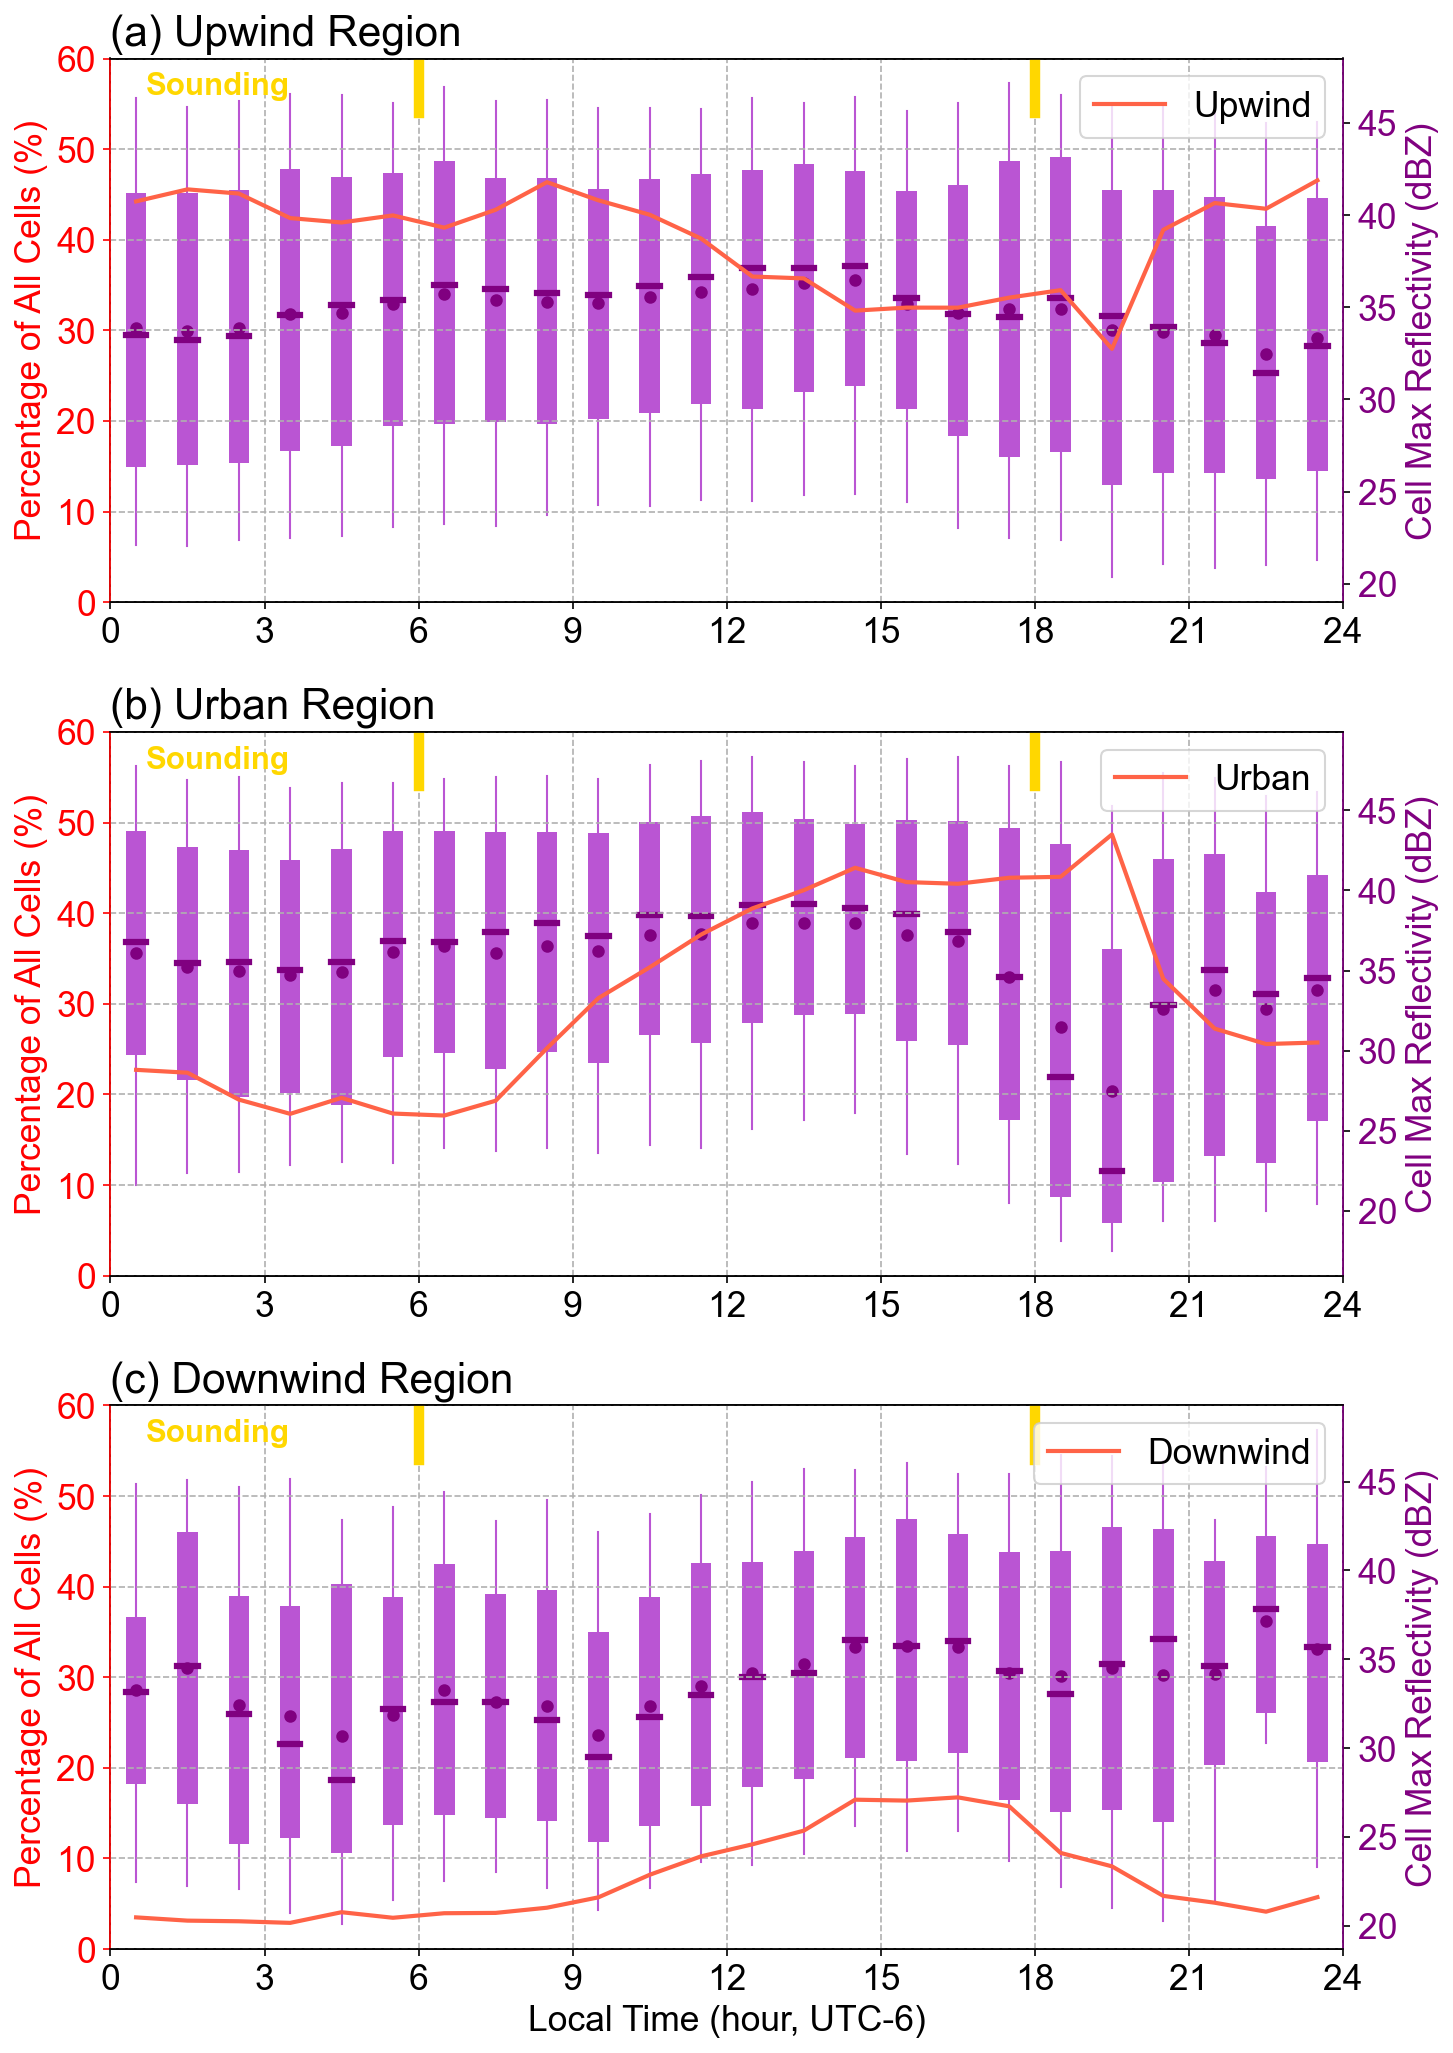

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Set matplotlib parameters
mpl.rcParams['font.size'] = 17
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['figure.facecolor'] = 'white'

# Create a 3-row, 1-column figure
fig, axes = plt.subplots(3, 1, figsize=[10, 14], dpi=150)  # Change to 3 rows, 1 column
sonde_times = [6, 18]
hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2

#-------------------------------------------
# First subplot (ax1)
ax1 = axes[0]
ax1.plot(hour_binv, hist_storms_in_upwind_wedge_LT_frac, color='tomato', lw=2, label='Upwind')
ax1.legend(loc='upper right', ncol=2)
ax1.grid(ls='--')
ax1.set_title('(a) Upwind Region', loc='left')
ax1.set_ylabel('Percentage of All Cells (%)')
ax1.set_ylim(0, 60)
ax1.set_xticks(np.arange(0,24.1,3))
ax1.set_xlim(0,24)
ax1.yaxis.label.set_color('red')
ax1.tick_params(axis='y', colors='red')
for ll in range(len(sonde_times)):
    ax1.axvline(sonde_times[ll], ymin=0.9, ymax=1, color='gold', lw=5)
ax1.text(3.5, 56, 'Sounding', color='gold', ha='right', fontsize=15, fontweight='bold')

# Boxplot settings for ax1
barcolor = 'mediumorchid'
boxprops_ = dict(linestyle='-', linewidth=0, color='none', facecolor=barcolor, alpha=1)
medianprops_ = dict(linestyle='-', linewidth=3, color='purple')
meanpointprops_ = dict(marker='o', markeredgecolor='purple', markerfacecolor='purple', markersize=5)
whiskerprops_ = dict(linewidth=1, linestyle='-', color=barcolor)

ax1b = ax1.twinx()
bp1 = ax1b.boxplot(cell_maxdbz_mean_hourbin_LT_upwind, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
                  boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
                  showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
ax1b.set_ylabel('Cell Max Reflectivity (dBZ)', color='purple')
ax1b.tick_params(axis='y', labelcolor='purple')
ax1.set_zorder(2)
ax1.patch.set_visible(False)
ax1.spines['left'].set_color('red')
ax1.spines['right'].set_color('purple')

#-----------------------------------------------
# Second subplot (ax2)
ax2 = axes[1]
ax2.plot(hour_binv, hist_storms_in_circle_LT_frac, color='tomato', lw=2, label='Urban')
ax2.legend(loc='upper right', ncol=2)
ax2.grid(ls='--')
ax2.set_title('(b) Urban Region', loc='left')
ax2.set_ylabel('Percentage of All Cells (%)')
ax2.set_ylim(0, 60)
ax2.set_xticks(np.arange(0,24.1,3))
ax2.set_xlim(0,24)
ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')
for ll in range(len(sonde_times)):
    ax2.axvline(sonde_times[ll], ymin=0.9, ymax=1, color='gold', lw=5)
ax2.text(3.5, 56, 'Sounding', color='gold', ha='right', fontsize=15, fontweight='bold')

# Boxplot settings for ax2
ax2b = ax2.twinx()
bp2 = ax2b.boxplot(cell_maxdbz_mean_hourbin_LT_circle, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
                  boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
                  showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
ax2b.set_ylabel('Cell Max Reflectivity (dBZ)', color='purple')
ax2b.tick_params(axis='y', labelcolor='purple')
ax2.set_zorder(2)
ax2.patch.set_visible(False)
ax2.spines['left'].set_color('red')
ax2.spines['right'].set_color('purple')

#-----------------------------------------------
# Third subplot (ax3)
ax3 = axes[2]
ax3.plot(hour_binv, hist_storms_in_downwind_wedge_LT_frac, color='tomato', lw=2, label='Downwind')
ax3.legend(loc='upper right', ncol=2)
ax3.grid(ls='--')
ax3.set_title('(c) Downwind Region', loc='left')
ax3.set_ylabel('Percentage of All Cells (%)')
ax3.set_xlabel('Local Time (hour, UTC-6)')
ax3.set_ylim(0, 60)
ax3.set_xticks(np.arange(0,24.1,3))
ax3.set_xlim(0,24)
ax3.yaxis.label.set_color('red')
ax3.tick_params(axis='y', colors='red')
for ll in range(len(sonde_times)):
    ax3.axvline(sonde_times[ll], ymin=0.9, ymax=1, color='gold', lw=5)
ax3.text(3.5, 56, 'Sounding', color='gold', ha='right', fontsize=15, fontweight='bold')

# Boxplot settings for ax3
ax3b = ax3.twinx()
bp3 = ax3b.boxplot(cell_maxdbz_mean_hourbin_LT_downwind, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
                  boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
                  showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
ax3b.set_ylabel('Cell Max Reflectivity (dBZ)', color='purple')
ax3b.tick_params(axis='y', labelcolor='purple')
ax3.set_zorder(2)
ax3.patch.set_visible(False)
ax3.spines['left'].set_color('red')
ax3.spines['right'].set_color('purple')

# Adjust layout and display the plot
fig.tight_layout()
plt.show()


In [39]:
hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2

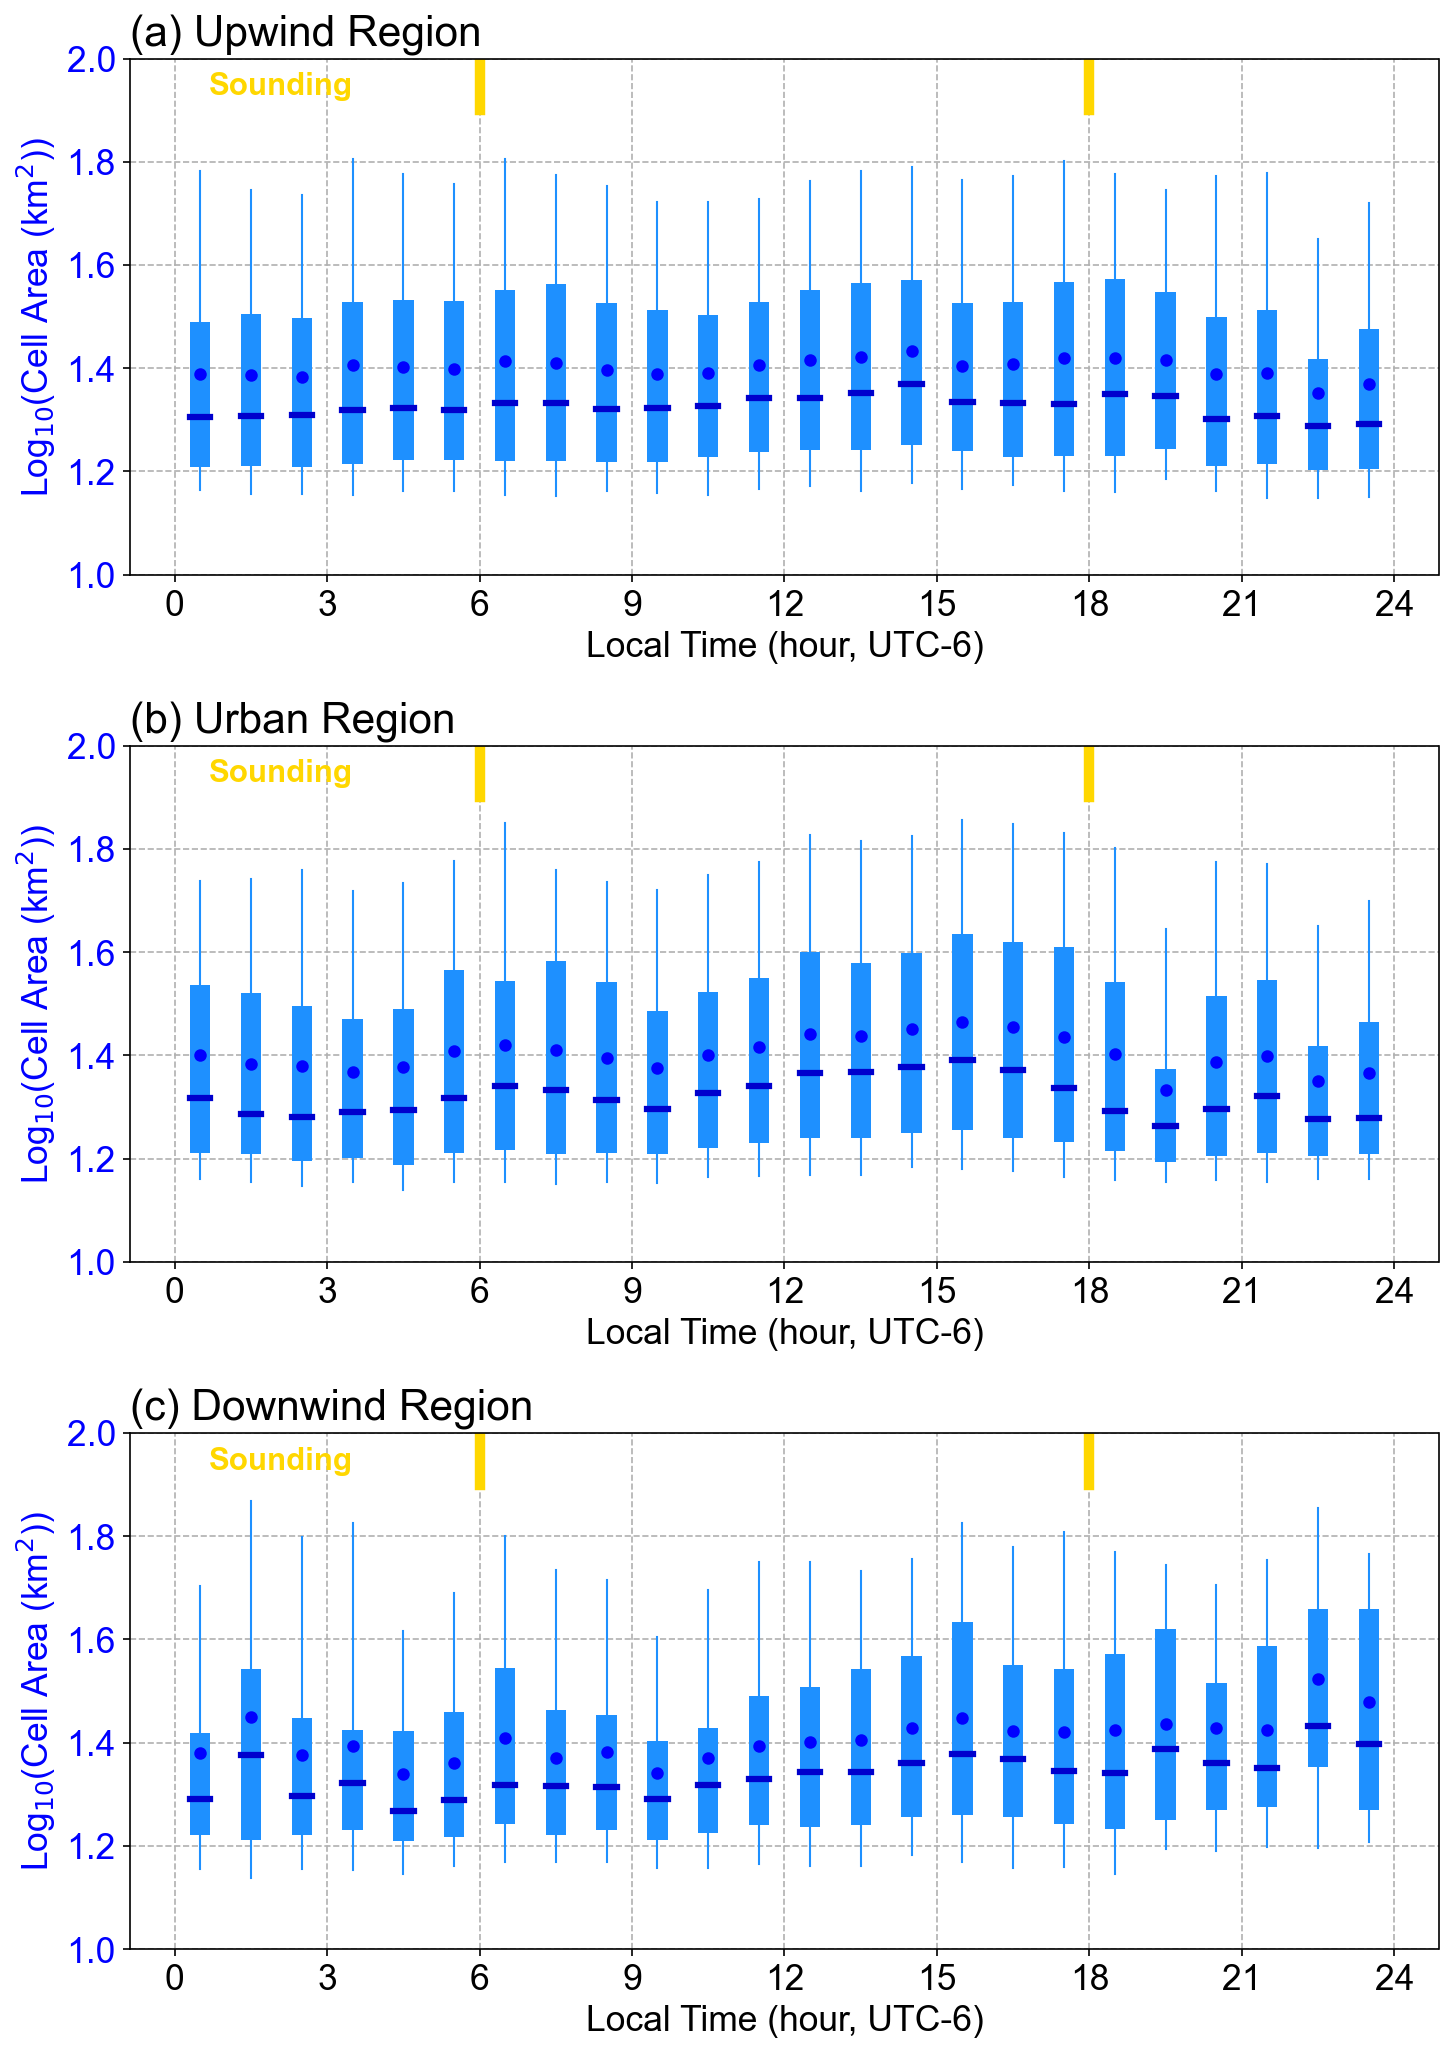

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Set matplotlib parameters
mpl.rcParams['font.size'] = 17
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['figure.facecolor'] = 'white'

# Create a 3-row, 1-column figure
fig, axes = plt.subplots(3, 1, figsize=[10, 14], dpi=150)
sonde_times = [6, 18]
hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2

# Boxplot settings
barcolor = 'mediumorchid'
boxprops_ = dict(linestyle='-', linewidth=0, color='none', facecolor='dodgerblue', alpha=1)
medianprops_ = dict(linestyle='-', linewidth=3, color='mediumblue')
meanpointprops_ = dict(marker='o', markeredgecolor='b', markerfacecolor='b', markersize=5)
whiskerprops_ = dict(linewidth=1, linestyle='-', color='dodgerblue')

# First subplot
ax1 = axes[0]
bp1 = ax1.boxplot(cell_area_mean_hourbin_LT_upwind, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
                  boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
                  showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
ax1.set_ylabel('Log$_{10}$(Cell Area (km$^2$))', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(ls='--')
ax1.set_title('(a) Upwind Region', loc='left')
ax1.set_xticks(np.arange(0,24.1,3))
ax1.set_xlabel('Local Time (hour, UTC-6)')
ax1.set_ylim([1, 2.0])  # Adjust the limits as needed
for ll in range(len(sonde_times)):
    ax1.axvline(sonde_times[ll], ymin=0.9, ymax=1, color='gold', lw=5)
ax1.text(3.5, 1.93, 'Sounding', color='gold', ha='right', fontsize=15, fontweight='bold')

# Second subplot
ax2 = axes[1]
bp2 = ax2.boxplot(cell_area_mean_hourbin_LT_circle, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
                  boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
                  showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
ax2.set_ylabel('Log$_{10}$(Cell Area (km$^2$))', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.grid(ls='--')
ax2.set_title('(b) Urban Region', loc='left')
ax2.set_xlabel('Local Time (hour, UTC-6)')
ax2.set_xticks(np.arange(0,24.1,3))
ax2.set_ylim([1, 2.0])  # Adjust the limits as needed
for ll in range(len(sonde_times)):
    ax2.axvline(sonde_times[ll], ymin=0.9, ymax=1, color='gold', lw=5)
ax2.text(3.5, 1.93, 'Sounding', color='gold', ha='right', fontsize=15, fontweight='bold')

# Third subplot
ax3 = axes[2]
bp3 = ax3.boxplot(cell_area_mean_hourbin_LT_downwind, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
                  boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
                  showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
ax3.set_ylabel('Log$_{10}$(Cell Area (km$^2$))', color='blue')
ax3.tick_params(axis='y', labelcolor='blue')
ax3.set_title('(c) Downwind Region', loc='left')
ax3.grid(ls='--')
ax3.set_xlabel('Local Time (hour, UTC-6)')
ax3.set_xticks(np.arange(0,24.1,3))
ax3.set_ylim([1, 2.0])  # Adjust the limits as needed
for ll in range(len(sonde_times)):
    ax3.axvline(sonde_times[ll], ymin=0.9, ymax=1, color='gold', lw=5)
ax3.text(3.5, 1.93, 'Sounding', color='gold', ha='right', fontsize=15, fontweight='bold')

# Adjust layout and display the plot
fig.tight_layout()
plt.show()


## Store the data

In [41]:
%store stats_downwind stats_upwind stats_circle

Stored 'stats_downwind' (Dataset)
Stored 'stats_upwind' (Dataset)
Stored 'stats_circle' (Dataset)


In [42]:
%store storms_in_upwind_wedge storms_in_circle storms_in_downwind_wedge

Stored 'storms_in_upwind_wedge' (DataArray)
Stored 'storms_in_circle' (DataArray)
Stored 'storms_in_downwind_wedge' (DataArray)
